In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **Imports**

In [ ]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import time
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math
from tensorflow.keras import layers
import keras


Initialized commands

In [ ]:
SEED = 1234
tf.random.set_seed(SEED)  
cwd = os.getcwd()

### **Functions and classes**

In [ ]:
# Read Masks 
def read_rgb_mask(mask_img):
    '''
    Given the image Returns the numpy array containing target values
    '''
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    
    new_mask_arr[np.where(np.all(mask_arr == [0 ,0 ,0],axis=-1))]=0
    new_mask_arr[np.where(np.all(mask_arr == [254 ,124 ,18],axis=-1))]=0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    new_mask_arr = np.expand_dims(new_mask_arr, -1) # to be received as an Image


    return new_mask_arr  

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined according to the different subset_list.

  """

  def __init__(self, dataset_dir,which_subset, subset_filenames, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    # if which_subset == 'training':
    #   subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    # elif which_subset == 'validation':
    #   subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    # with open(subset_file, 'r') as f:
    #   lines = f.readlines()
    
    # subset_filenames = []
    # for line in lines:
    #   subset_filenames.append(line.strip()) 
    out_mask=np.zeros([256,256,1])
    self.out_mask=out_mask
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]

    
    if (curr_filename+'.jpg') in (os.listdir(os.path.join(self.dataset_dir, 'Haricot', 'Images'))):
        img = Image.open(os.path.join(self.dataset_dir, 'Haricot', 'Images', curr_filename  + '.jpg'))
        mask = Image.open(os.path.join(self.dataset_dir, 'Haricot', 'Masks', curr_filename  + '.png'))

    else:
        img = Image.open(os.path.join(self.dataset_dir, 'Mais', 'Images', curr_filename  + '.jpg'))
        mask = Image.open(os.path.join(self.dataset_dir, 'Mais', 'Masks', curr_filename  + '.png'))



    # img = Image.open(os.path.join(self.dataset_dir, 'Haricot', 'Images', curr_filename))
    # img = Image.open(os.path.join(self.dataset_dir, 'Mais', 'Images', curr_filename))

    # mask = Image.open(os.path.join(self.dataset_dir, 'Haricot', 'Masks', curr_filename))
    # mask = Image.open(os.path.join(self.dataset_dir, 'Mais', 'Masks', curr_filename))


    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = read_rgb_mask(mask)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        self.out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            self.out_mask += curr_class_arr
    else:
      self.out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    # return img_arr, np.float32(out_mask)
    return img_arr.reshape([256,256,3]),np.float32(self.out_mask).reshape([256,256,1])

#**Load The DATA** 


### Unzip the file


In [ ]:
# Run this cell only if you are using Colab with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/My\ Drive/Development_Dataset.zip

Archive:  /content/drive/My Drive/Development_Dataset.zip
replace Development_Dataset/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls Development_Dataset/Training/

Bipbip


##Split the train dataset and validation 


In this part we divide each image directory into training and validation. Indeed, we create two lists one for training and one for validation images. This happens for Haricot_Bipbip, Mais_Bipbip, Haricot_Pead, Mais_Pead, Haricot_Roseau, Mais_Roseau, Haricot_Weedelec, Mais_Weedelec. At the end, for each team, training images and validation images for both Haricot and Mais are concatinated.

In [ ]:

training_splitter = 0.8
teams_images = ['Bipbip']
cwd = os.path.join(os.getcwd(),'Development_Dataset', 'Training')
train_valid_splitter = {}
for team in teams_images:
  Haricot_images = os.listdir(os.path.join(cwd,team,'Haricot','Images'))
  Mais_images = os.listdir(os.path.join(cwd,team,'Mais','Images')) 
  random.shuffle(Haricot_images)
  random.shuffle(Mais_images)
  train_valid_splitter[team + '_Haricot_training']= [image[:-4] for image in Haricot_images[:math.ceil((len(Haricot_images)*training_splitter))]]
  train_valid_splitter[team+'_Haricot_validation'] = [image[:-4] for image in Haricot_images[math.ceil(len(Haricot_images)*training_splitter):]]

  train_valid_splitter[team+'_Mais_training'] = [image[:-4] for image in Mais_images[:math.ceil(len(Mais_images)*training_splitter)]]
  train_valid_splitter[team+'_Mais_validation'] = [image[:-4] for image in Mais_images[math.ceil(len(Mais_images)*training_splitter):]]

  #Concatinate Haricot and Mais training images and  Haricot and Mais validation images for each team
  train_valid_splitter[team + '_training']= train_valid_splitter[team + '_Haricot_training'] + train_valid_splitter[team+'_Mais_training']
  train_valid_splitter[team + '_validation']= train_valid_splitter[team + '_Haricot_validation'] + train_valid_splitter[team+'_Mais_validation']



In [ ]:
# See lists of training and validation lists
train_valid_splitter.keys()

dict_keys(['Bipbip_Haricot_training', 'Bipbip_Haricot_validation', 'Bipbip_Mais_training', 'Bipbip_Mais_validation', 'Bipbip_training', 'Bipbip_validation'])

In [ ]:
#Create a dictionary in order to store image directory adresses
img_dir_names_dic = dict()
lst1 = ['Bipbip','Pead', 'Roseau', 'Weedelec']
# lst2 = ['Haricot', 'Mais']
common_add = os.path.join(os.getcwd(),'Development_Dataset','Training')
for name in lst1:
  img_dir_names_dic[name] = os.path.join(common_add , name)
  # for crop in lst2:
    # img_dir_names_dic[name + '_'+crop] = os.path.join(common_add , name , crop)

In [ ]:
img_dir_names_dic

{'Bipbip': '/content/Development_Dataset/Training/Bipbip',
 'Pead': '/content/Development_Dataset/Training/Pead',
 'Roseau': '/content/Development_Dataset/Training/Roseau',
 'Weedelec': '/content/Development_Dataset/Training/Weedelec'}

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256
dataset_Bipbip = CustomDataset(img_dir_names_dic['Bipbip'], 'training', train_valid_splitter['Bipbip_training'], 
                        img_generator=img_data_gen, mask_generator=mask_data_gen, 
                        preprocessing_function=preprocess_input)

dataset_valid_Bipbip = CustomDataset(img_dir_names_dic['Bipbip'], 'validation', train_valid_splitter['Bipbip_validation'], 
                              preprocessing_function=preprocess_input)

In [ ]:

train_dataset_Bipbip= tf.data.Dataset.from_generator(lambda: dataset_Bipbip,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset_Bipbip = train_dataset_Bipbip.batch(32)

train_dataset_Bipbip = train_dataset_Bipbip.repeat()

valid_dataset_Bipbip = tf.data.Dataset.from_generator(lambda: dataset_valid_Bipbip,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset_Bipbip = valid_dataset_Bipbip.batch(32)

valid_dataset_Bipbip = valid_dataset_Bipbip.repeat()

Test and visualize the data generator

In [ ]:
# Assign a color to each class

evenly_spaced_interval = np.linspace(0, 1, 2)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset_Bipbip)

[0. 1. 2.]


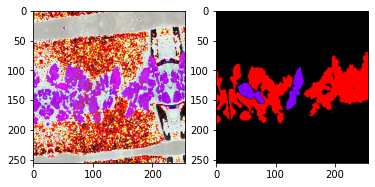

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

# **U-Net Architecture**
https://keras.io/examples/vision/oxford_pets_image_segmentation/



In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
img_size=(256,256)
num_classes=3
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### **Training model**

https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/AN2DL_prj2/', 'U-Net Segmentattion')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'U-Net'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

#Save Best Model
callbacks.append(keras.callbacks.ModelCheckpoint("Best_Model", save_best_only=True))

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)

# reduce learning rate
# --------------
reduce_learning_rate = True
if reduce_learning_rate:
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                         patience=2, verbose=1)
    callbacks.append(reduce_learning_rate)

model.fit(x=train_dataset_Bipbip,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(dataset_Bipbip),
          validation_data=valid_dataset_Bipbip,
          validation_steps=len(dataset_valid_Bipbip), 
          callbacks=callbacks)



Epoch 1/20


#**Test model for U-Net**

## Visualization of the performance

In [ ]:
#Create a dictionary in order to store image directory adresses

import os
img_dir_names_dic = dict()
img_dir_names_dic1=dict()
lst1 = ['Bipbip']
lst2 = ['Haricot', 'Mais']
common_add = os.path.join(os.getcwd(),'Development_Dataset','Test_Dev')
for name in lst1:
  img_dir_names_dic[name] = os.path.join(common_add , name)
  for crop in lst2:
    img_dir_names_dic1[name + '_'+crop] = os.path.join(common_add , name , crop)
subset_file = os.path.join(img_dir_names_dic1['Bipbip_Haricot'])


In [ ]:
test_dataset_Bipbip = tf.data.Dataset.from_generator(lambda: test_dataset_Bipbip,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
test_dataset_Bipbip = test_dataset_Bipbip.batch(32)

test_dataset_Bipbip = test_dataset_Bipbip.repeat()

In [ ]:
import time
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

iterator = iter(test_dataset_Bipbip)
#iterator = iter(valid_dataset_Bipbip)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
 target_img[np.where(target == i)] = np.array(colors[i-1])[:3] *255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)


## Submission for delivery

In [1]:
import os
import json
import numpy as np
from PIL import Image

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# test_dev_dir ="Development_Dataset/Test_Dev/"
# team = 'Bipbip' | 'Pead' | 'Roseau' | 'Weedelec' 
# crop = 'Haricot' |  'Mais'
 


def submit(submission_dict,team,crop):

    path ="Development_Dataset/Test_Dev/"
    dir= os.path.join(path,team,crop,'Images')
    predected_imges =next(os.walk(dir))[2]

    for img in predected_imges:
      # load mask <- HERE you should have your segmentation model instead

      #read the image
      test_image = Image.open(os.path.join(dir,img))
      size=(256,256)
      test_image = test_image.resize(size)
      #image size

      #test_image = image.imread(os.path.join(dir,img))
      tf_test_image = tf.convert_to_tensor(
      np.array(test_image), dtype='float32'
      )
      out_sigmoid = model.predict(x=tf.expand_dims(tf_test_image, 0))
      predicted_class = tf.argmax(out_sigmoid, -1)
      predicted_class = predicted_class[0, ...]
   
      mask_arr = np.uint8(predicted_class) #read_rgb_mask(os.path.join(dir, img))

      #----------------------------- ['team'] 'Bipbip' ['crop'] 'Haricot'
      img_name = img[:-4]
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = mask_arr.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = crop
      submission_dict[img_name]['segmentation'] = {}

      # RLE encoding
      # crop
      rle_encoded_crop = rle_encode(mask_arr == 1)
      # weed
      rle_encoded_weed = rle_encode(mask_arr == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

      
    return submission_dict


def submission():
  submission_dict = {}

  submission_dict = submit(submission_dict,'Bipbip','Haricot')
  submission_dict = submit(submission_dict,'Bipbip','Mais')

  # submission_dict = submit(submission_dict,'Pead','Haricot')
  # submission_dict = submit(submission_dict,'Pead','Mais')

  # submission_dict = submit(submission_dict,'Roseau','Haricot')
  # submission_dict = submit(submission_dict,'Roseau','Mais')

  # submission_dict = submit(submission_dict,'Weedelec','Haricot')
  # submission_dict = submit(submission_dict,'Weedelec','Mais')


 

  # Finally, save the results into the submission.json file
  with open('submission.json', 'w') as f:
      json.dump(submission_dict, f)

In [ ]:
submission()

In [ ]:

#Test
def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)




# Just for completeness, here we show how the rle encoded mask
# is transformed back to a numpy array

# Read the submission.json file generated by the
# 'prepare_submission.py' script
with open('submission.json', 'r') as f:
    submission_dict = json.load(f)
img_shape = submission_dict[img_name]['shape']
rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']
crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)
reconstructed_mask = crop_mask + (weed_mask * 2)

reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])

reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

In [ ]:
reconstructed_rgb_arr

In [ ]:


def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)




# Just for completeness, here we show how the rle encoded mask
# is transformed back to a numpy array

# Read the submission.json file generated by the
# 'prepare_submission.py' script
with open('submission.json', 'r') as f:
    submission_dict = json.load(f)

img_name = 'Bipbip_haricot_im_07421'
img_shape = submission_dict[img_name]['shape']

rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

# Reconstruct crop and weed binary masks
crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

# Reconstruct original mask
# weed_mask * 2 allows to convert ones into target 2 (weed label)
reconstructed_mask = crop_mask + (weed_mask * 2)

# Just for visualisation purposes, save RGB reconstructed mask
# Use again the dictionary in 'RGBtoTarget.txt'.
reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

reconstructed_rgb_img = Image.fromarray(
    np.uint8(reconstructed_rgb_arr))

reconstructed_rgb_img.save('Development_Dataset/rle_decoded_rgb_mask.png')

# **Other Efforts**

### Other U-Net

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(filters=3,kernel_size= (1, 1),strides=(1,1),padding='same', activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((256, 256, 3))
mysmodel=tf.keras.Sequential()
mysmodel.add(Resmodel)
mysmodel.add(get_unet(input_img=input_img,n_filters=256))

### **Vgg-Unet with Fine Tuning**

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()

finetuning = True

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False
    


In [ ]:
from tensorflow.keras import layers
import keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
img_size=(256,256)
num_classes=3
# Build model
model=keras.Sequential()
model.add(vgg)
model = get_model(img_size, num_classes)
model.summary()

###**Keras Segmentation Vgg Unet**

In [ ]:
from keras_segmentation.models.unet import vgg_unet
!pip install git+https://github.com/qubvel/segmentation_models
!apt-get install -y libsm6 libxext6 libxrender-dev
!pip install opencv-python
#from segmentation_models.unet import vgg_unet


Building the model

In [ ]:
img_input = Input(shape=(256,256 , 3 ))
vggunetmodel = vgg_unet(n_classes=51 ,  input_height=416, input_width=608  )

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(vggunet)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)



This is just to show that we could have used any model instead of Vgg

In [ ]:
from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12
pre_model = pspnet_50_ADE_20K() # load the pretrained model trained on ADE20k dataset


In [ ]:
from keras_segmentation.models.unet import vgg_unet
pre_model = vgg_unet(n_classes=3 ,  input_height=256, input_width=256  )

Getting rid of the last layer to do the segmentation better

In [ ]:
pre_model.layers.pop()
premodel.outputs = [pre_model.layers[-1].output]
model=tf.keras.Sequential()
for layer in pre_model.layer[:,-1]:# go through until the last layer
  model.add(layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())  
x=model.add(Dens(3,activation='relu'))
x=model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax', name='predictions')
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()


The above one did not worked

In [ ]:
def ConvBlock(X,channel,kernel_size,bn=True):
  x=layers.Conv2D(filters=channel,kernel_size=(kernel_size,kernel_size),strides=(1,1),dilation_rate=(1,1),padding='SAME',kernel_initializer='he_normal')(X)
  if bn:
    x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  x=layers.Conv2D(filters=channel,kernel_size=(kernel_size,kernel_size),strides=(1,1),dilation_rate=(1,1),padding='SAME',kernel_initializer='he_normal')(x)
  if bn:
    x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  return x

## **ResNet 34 , Skip Connection**




The same thing as before but this time we have used Resnet 34,
We used some of the connectinos as skip connectinos

In [ ]:
from classification_models.keras import Classifiers

ResNet34, preprocess_input = Classifiers.get('resnet34')
Resmodel = ResNet34((256, 256, 3), weights='imagenet') 
Resmodel.summary()

In [ ]:
def ConvBlock(X,channel,kernel_size,bn=True):
  x=layers.Conv2D(filters=channel,kernel_size=(kernel_size,kernel_size),strides=(1,1),dilation_rate=(1,1),padding='SAME',kernel_initializer='he_normal')(X)
  if bn:
    x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)

  x=layers.Conv2D(filters=channel,kernel_size=(kernel_size,kernel_size),strides=(1,1),dilation_rate=(1,1),padding='SAME',kernel_initializer='he_normal')(x)
  if bn:
    x=layers.BatchNormalization()(x)
  x=layers.Activation('relu')(x)
  return x


In [ ]:
def new_model(output_channel,output_activation):
  inp=Resmodel.input

  skip1=Resmodel.layers[5].output #128x128x64
  skip2=Resmodel.layers[37].output #64x64x64
  skip3=Resmodel.layers[74].output #32x32x128
  skip4=Resmodel.layers[129].output #16x16x256
  encoder_final=Resmodel.layers[157].output #8x8x512

  #upsample 
  filters=256
  k=1

  x=layers.UpSampling2D()(encoder_final) #returns 16x16x256
  x=layers.Concatenate()([x,skip4]) #returns 16x16x512
  x=ConvBlock(x,filters,kernel_size=3) #returns 16x16x256
  filters //=2

  x=layers.UpSampling2D()(x) #returns 32x32x128
  x=layers.Concatenate()([x,skip3]) #returns 32x32x256
  x=ConvBlock(x,filters,kernel_size=3) #returns 32x32x128
  filters //=2

  x=layers.UpSampling2D()(x) #returns 64x64x64
  x=layers.Concatenate()([x,skip2]) #returns 64x64x128
  x=ConvBlock(x,filters,kernel_size=3) #returns 64x64x64
  filters //=2 

  x=layers.UpSampling2D()(x) #returns 128x128x64
  x=layers.Concatenate()([x,skip1]) #returns 128x128x128
  x=ConvBlock(x,filters,kernel_size=3) #returns 128x128x32
  filters //=2

  x=layers.UpSampling2D()(x) #returns 256x256x32
  x=ConvBlock(x,filters,kernel_size=3) #returns 256x256x16
  x = layers.Conv2D(output_channel, kernel_size= (1,1), strides=(1,1), padding= 'same')(x)  #returns 256x256x1
  x=layers.Activation('sigmoid')(x)
  model=Model(inputs=inp,outputs=x)
  return model


In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
# ------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

##**another U-net**




Well we just put this to make our salad table more fancy. Not our work. but searching (who didn't?)throuhg internet puting one another alternative for U-net. 

In [ ]:
def my_unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model